=== scikit-learn LogisticRegression ===
coef: [23.21841917  1.26650875]
intercept: 2.579736223591141
train acc: 0.9866666666666667 test acc: 0.9866666666666667

=== Keras (sigmoid activation, Adam) ===
weights: [5.25698615 0.54730741]
bias: 0.236324936819106
train acc: 0.9866666666666667 test acc: 0.9866666666666667

=== Keras (logit output, full-batch SGD) ===
weights: [4.45168096 0.6700742 ]
bias: 0.12333950759176601
train acc: 0.9777777777777777 test acc: 0.9866666666666667

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
After copying weights: max prob diff (sklearn vs nn_copy): 1.1102230246251565e-16
Predictions identical? True

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 701us/step


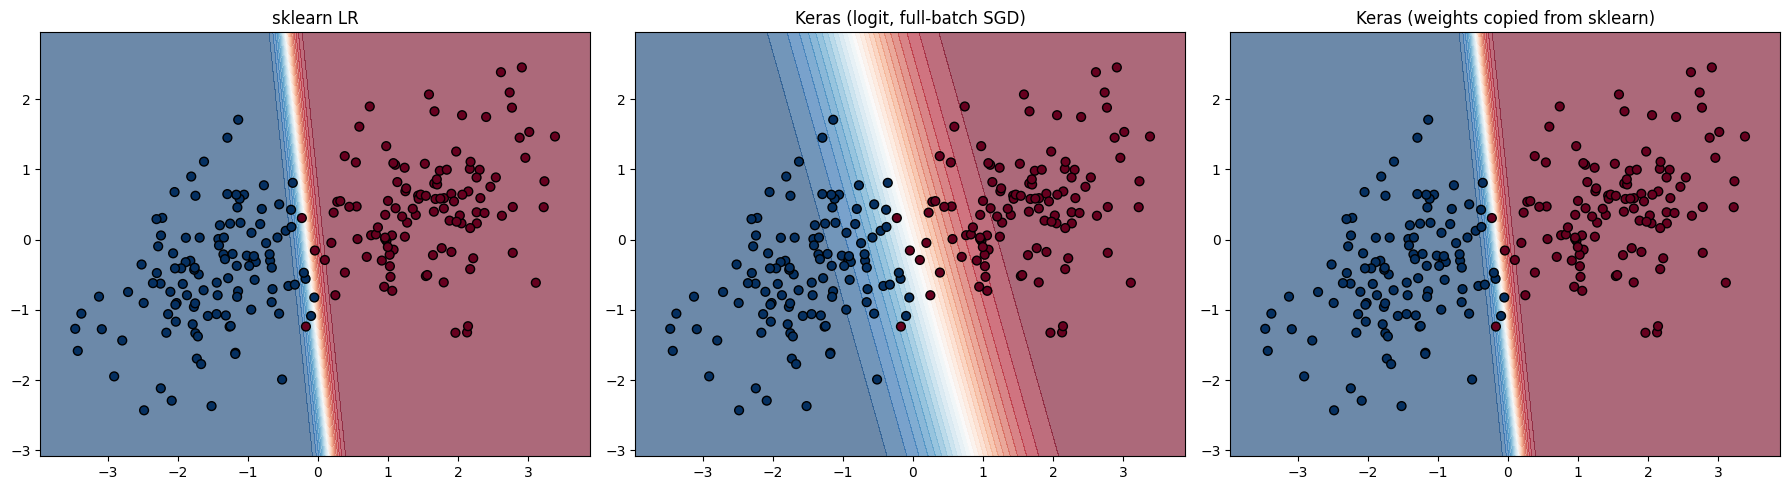

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


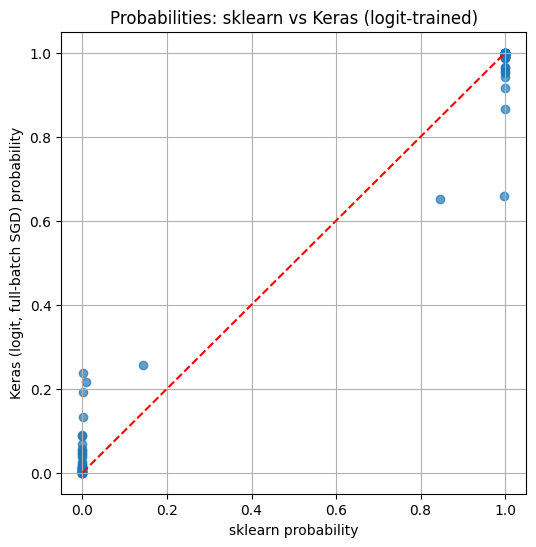

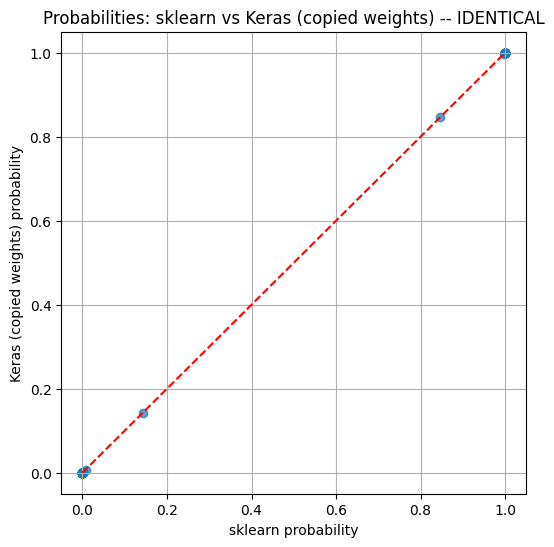

In [1]:
"""
demo_logistic_vs_nn_simple.py

Goal: show equivalence between logistic regression and a single-layer NN on simple synthetic data.
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# -------------------------
# 0) Repro / float
# -------------------------
np.random.seed(0)
tf.random.set_seed(0)
tf.keras.backend.set_floatx("float64")   # use double precision to reduce numeric differences

# -------------------------
# 1) Synthetic 2D dataset
# -------------------------
# Create two Gaussian blobs separated by a linear boundary
n_per_class = 150
mean0 = [-1.5, -0.5]
mean1 = [1.5, 0.5]
cov = [[0.6, 0.2], [0.2, 0.6]]

X0 = np.random.multivariate_normal(mean0, cov, size=n_per_class)
X1 = np.random.multivariate_normal(mean1, cov, size=n_per_class)
X = np.vstack([X0, X1])
y = np.hstack([np.zeros(n_per_class), np.ones(n_per_class)]).astype(int)

# Shuffle + split
idx = np.random.permutation(len(X))
X, y = X[idx], y[idx]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

# Standardize features (use same scaler for both methods)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# -------------------------
# 2) scikit-learn logistic regression (LBFGS)
# -------------------------
lr = LogisticRegression(penalty=None, solver="lbfgs", max_iter=10000)
lr.fit(X_train_s, y_train)

print("=== scikit-learn LogisticRegression ===")
print("coef:", lr.coef_.flatten())
print("intercept:", lr.intercept_[0])
print("train acc:", lr.score(X_train_s, y_train), "test acc:", lr.score(X_test_s, y_test))
print()

# -------------------------
# 3) Keras: simple sigmoid output (quick demo)
# -------------------------
nn_sig = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(1, activation='sigmoid', dtype='float64')
])

nn_sig.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
               loss='binary_crossentropy',
               metrics=['accuracy'])

nn_sig.fit(X_train_s, y_train, epochs=300, batch_size=32, verbose=0)
w_sig, b_sig = nn_sig.layers[0].get_weights()
print("=== Keras (sigmoid activation, Adam) ===")
print("weights:", w_sig.flatten())
print("bias:", b_sig[0])
print("train acc:", nn_sig.evaluate(X_train_s, y_train, verbose=0)[1],
      "test acc:", nn_sig.evaluate(X_test_s, y_test, verbose=0)[1])
print()

# -------------------------
# 4) Keras: logit output + from_logits=True, full-batch SGD -> closer to LBFGS/Deterministic
# -------------------------
# Use raw logits (no sigmoid) and BinaryCrossentropy(from_logits=True)
nn_logit = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(1, activation=None, dtype='float64')  # outputs logits
])

# full-batch gradient descent (batch_size = full train set) to emulate deterministic optimization
# low learning rate with many epochs tends to converge close to LBFGS solution on simple data
opt = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
nn_logit.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

# Full-batch training: set batch_size = len(X_train_s)
nn_logit.fit(X_train_s, y_train, epochs=8000, batch_size=len(X_train_s), verbose=0)

w_logit, b_logit = nn_logit.layers[0].get_weights()
print("=== Keras (logit output, full-batch SGD) ===")
print("weights:", w_logit.flatten())
print("bias:", b_logit[0])
print("train acc:", nn_logit.evaluate(X_train_s, y_train, verbose=0)[1],
      "test acc:", nn_logit.evaluate(X_test_s, y_test, verbose=0)[1])
print()

# -------------------------
# 5) Copy sklearn weights -> Keras (proof of identity)
# -------------------------
# Pack sklearn weights into Keras layer shape (input_dim, units)
w_skl = lr.coef_.flatten()
b_skl = float(lr.intercept_[0])

W_for_keras = w_skl.reshape(-1, 1).astype(np.float64)
b_for_keras = np.array([b_skl], dtype=np.float64)

# Build a model with sigmoid activation and set sklearn weights
nn_copy = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(1, activation='sigmoid', dtype='float64')
])
nn_copy.layers[0].set_weights([W_for_keras, b_for_keras])

# Verify identical probabilities / predictions
prob_lr_test = lr.predict_proba(X_test_s)[:,1]
prob_nn_copy = nn_copy.predict(X_test_s).flatten()
print("After copying weights: max prob diff (sklearn vs nn_copy):", np.max(np.abs(prob_lr_test - prob_nn_copy)))
print("Predictions identical?", np.array_equal((prob_lr_test > 0.5).astype(int), (prob_nn_copy > 0.5).astype(int)))
print()

# -------------------------
# 6) Plots: decision boundary and prob scatter
# -------------------------
def plot_decision_boundary(model_predict_fn, title, ax=None):
    if ax is None:
        ax = plt.gca()
    # grid in original feature space (before scaling)
    xx = np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 200)
    yy = np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 200)
    XX, YY = np.meshgrid(xx, yy)
    grid = np.column_stack([XX.ravel(), YY.ravel()])
    grid_s = scaler.transform(grid)
    probs = model_predict_fn(grid_s).reshape(XX.shape)
    cs = ax.contourf(XX, YY, probs, levels=25, cmap='RdBu_r', alpha=0.6)
    ax.scatter(X_train[:,0], X_train[:,1], c=y_train, edgecolor='k', s=40, cmap='RdBu_r')
    ax.set_title(title)
    return cs

fig, axes = plt.subplots(1, 3, figsize=(18,5))

# sklearn probability function
plot_decision_boundary(lambda Xs: lr.predict_proba(Xs)[:,1], "sklearn LR", ax=axes[0])
# keras logit model probability
plot_decision_boundary(lambda Xs: 1/(1+np.exp(-nn_logit.predict(Xs).flatten())), "Keras (logit, full-batch SGD)", ax=axes[1])
# keras with copied weights
plot_decision_boundary(lambda Xs: nn_copy.predict(Xs).flatten(), "Keras (weights copied from sklearn)", ax=axes[2])

plt.tight_layout()
plt.show()

# Probability scatter: compare sklearn vs keras logit-trained
prob_nn_logit = 1/(1+np.exp(-nn_logit.predict(X_test_s).flatten()))
plt.figure(figsize=(6,6))
plt.scatter(prob_lr_test, prob_nn_logit, alpha=0.7)
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("sklearn probability")
plt.ylabel("Keras (logit, full-batch SGD) probability")
plt.title("Probabilities: sklearn vs Keras (logit-trained)")
plt.grid(True)
plt.show()

# Also plot probabilities for the copied-model vs sklearn (should be identical)
plt.figure(figsize=(6,6))
plt.scatter(prob_lr_test, prob_nn_copy, alpha=0.7)
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("sklearn probability")
plt.ylabel("Keras (copied weights) probability")
plt.title("Probabilities: sklearn vs Keras (copied weights) -- IDENTICAL")
plt.grid(True)
plt.show()
